# 04 - Modeling, Evaluation, and Conclusion

References: 

1. Intro to Classification + KNN. General Assembly.

2. Classification Metrics II. General Assembly.

3. [Hyperparameter Tuning](https://www.geeksforgeeks.org/hyperparameter-tuning/). Geeks for Geeks.

4. [Hyperparameters of Random Forest Classifier](https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/). Geeks for Geeks.

5. [Hyperparameter Tuning with Grid Search](https://www.relataly.com/hyperparameter-tuning-with-grid-search/2261/). Florian Follonier.

## Introduction

In this section, I complete the modeling process. While my initial thought was to create models using logistic regression, it did not seem to be the best fit, since some of the variables represent repeated measurements of the same features, and some are therefore highly correlated.

Instead, I decided to create KNN models. In choosing the K value, I tested values of approximately 3 to 25 and selected the one that had the optimal results. Accuracy, specificity, sensitivity, precision, and F1 scores are calcualated for each model. The main metric used to evaluate the models is the F1 score, as it takes into account how accurately the model predicted positive and negative classes individually.

With the two highest-scoring datasets, I also created Random Forest Classification models for each individually, then together. As the grand finale, I also created a Random Forest Classifier using all of the 116 variables selected for modeling. In conclusion, I offer my thoughts on the findings and their meaning in the context of the current prevalence of diabetes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, f1_score, classification_report, RocCurveDisplay)

from sklearn.model_selection import RepeatedKFold

from sklearn import datasets

from sklearn.datasets import load_digits
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             classification_report, plot_confusion_matrix)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

import warnings

# Part I - Predicting by Subcategory

## I. Health

### Data Import

In [2]:
file_path = '../data/FoodEnvironmentAtlas.xls.HEALTH_Modeling.csv'

health = pd.read_csv(file_path)

In [3]:
health.head()

,fips,state,county,recfac11,recfac16,recfacpth11,recfacpth16,pct_mhs18,pct_mhs1825,pct_mhs26,rank18,per100th18,rank17,per100th17,pct_diabetes18,class
0,1001,AL,Autauga,4,6,0.072465,0.108542,13.0,11.0,13.0,51.0,92.6,51.0,85.0,9.5,1.0
1,1003,AL,Baldwin,16,21,0.085775,0.101200,13.0,11.0,13.0,51.0,92.6,51.0,85.0,8.4,0.0
2,1005,AL,Barbour,2,0,0.073123,0.000000,13.0,11.0,13.0,51.0,92.6,51.0,85.0,13.5,1.0
3,1007,AL,Bibb,0,1,0.000000,0.044183,13.0,11.0,13.0,51.0,92.6,51.0,85.0,10.2,1.0
4,1009,AL,Blount,3,4,0.052118,0.069490,13.0,11.0,13.0,51.0,92.6,51.0,85.0,10.5,1.0


I will begin by viewing a correlation chart.

In [4]:
health.corr()

,fips,recfac11,recfac16,recfacpth11,recfacpth16,pct_mhs18,pct_mhs1825,pct_mhs26,rank18,per100th18,rank17,per100th17,pct_diabetes18,class
fips,1.000000,-0.047586,-0.048530,0.043734,0.038399,0.087920,0.120429,0.105016,0.104063,-0.069296,0.114710,-0.075347,-0.083778,-0.084537
recfac11,-0.047586,1.000000,0.992103,0.192325,0.228682,-0.037991,-0.046766,-0.028387,-0.118779,0.126471,-0.116033,0.122345,-0.013019,0.007270
recfac16,-0.048530,0.992103,1.000000,0.164929,0.226508,-0.050920,-0.058813,-0.043072,-0.104611,0.113222,-0.103222,0.110073,-0.016741,0.004168
recfacpth11,0.043734,0.192325,0.164929,1.000000,0.732171,0.133334,0.143773,0.137837,-0.117252,0.116344,-0.108793,0.109339,-0.107797,-0.064739
recfacpth16,0.038399,0.228682,0.226508,0.732171,1.000000,0.093831,0.106529,0.101534,-0.100789,0.108964,-0.094971,0.103496,-0.098824,-0.040406
pct_mhs18,0.087920,-0.037991,-0.050920,0.133334,0.093831,1.000000,0.890867,0.985673,-0.412848,0.391162,-0.399418,0.368434,-0.065794,-0.046338
pct_mhs1825,0.120429,-0.046766,-0.058813,0.143773,0.106529,0.890867,1.000000,0.873708,-0.466243,0.430006,-0.452188,0.414360,-0.124984,-0.113037
pct_mhs26,0.105016,-0.028387,-0.043072,0.137837,0.101534,0.985673,0.873708,1.000000,-0.425461,0.398860,-0.413220,0.378415,-0.045691,-0.024914
rank18,0.104063,-0.118779,-0.104611,-0.117252,-0.100789,-0.412848,-0.466243,-0.425461,1.000000,-0.964312,0.994863,-0.959811,0.152394,0.107410
per100th18,-0.069296,0.126471,0.113222,0.116344,0.108964,0.391162,0.430006,0.398860,-0.964312,1.000000,-0.962105,0.996991,-0.144658,-0.102972


None of these variables appear highly correlated to the prevalence of diabetes. The strongest correlations are the -0.14/15 values seen between the number of MH practitioners per 100 thousand for 2017 and 2018.

I will still see what score they get, altogether.

#### 1. Create X and y

In [5]:
X = health.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = health['class']

#### 2. Create baseline value

In [6]:
health['class'].value_counts(normalize=True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

The baseline, or majority class, is 0.583.

#### 3. Scale Values

In [7]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2356, 11), (786, 11), (2356,), (786,))

#### 5. Instantiate, Fit, Evaluate

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors=10)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.7597623089983022 0.7239185750636132


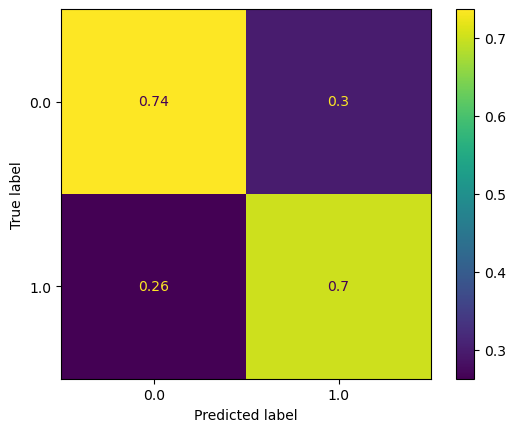

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [13]:
confusion_matrix(y_test, preds).ravel()

array([375,  83, 134, 194])

In [14]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [15]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(375, 83, 134, 194)

##### Accuracy (pre-determined above)

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.7239185750636132


This is the proportion of total predictions that were correct. The score of 0.723 is above the baseline (which was 0.583.) 

##### Specificity

In [17]:
specificity = tn / (tn + fp)

specificity

0.8187772925764192

This is the proportion of total negatives that were predicted correctly. This is a relatively high score of 0.819.

##### Sensitivity/Recall

In [18]:
sensitivity = tp / (tp + fn)

sensitivity

0.5914634146341463

This is the proportion of total positives that were predicted correctly. The sensitivity is much lower than the specificity on this occasion, with a score of 0.591.

##### Precision 

In [19]:
precision = tp / (tp + fp)

precision

0.7003610108303249

This is the proportion of predicted positives that were actually positive. The score of 0.700 is favorable.

##### F-1 score

In [20]:
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)

f1

0.6413223140495866

The f1 score combines precision and sensitivity scores, and gives us an overall score through which to evaluate the model. The f-1 score of 0.641 exceeds baseline.

### Discussion

Using the health-related features of recreational facilities, number of mental health providers, and percentage of adult population that received mental health services in the last year, I was able to create a model to predict prevalence of diabetes. 

The scores above show that the majority of counties were predicted correctly, though low prevalence was predicted more accurately than high prevalence.

Because the Health dataset has been shown to be predictive, I will use Random Forest Classification with Grid Search in order to maximize its predictive power. 

### Random Forest Classification

#### 1. Instantite & Fit the Model

In [21]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

In [22]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 2. Generate initial score

In [23]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9456706281833617, 0.7366412213740458)

There is a great deal of overfit, but the accuracy score is 0.737.

#### 3. Grid search for best parameters

In [24]:
grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 6789),
                    param_grid = {'max_depth': [2, 8, 12, 16],
                                  'n_estimators':[20, 80, 120, 240],
                                 'min_samples_split': [2, 4, 6, 8],
                                 'min_samples_leaf': [2, 3, 4, 5, 6]},
                    
                                  cv=5, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=6789),
             param_grid={'max_depth': [2, 8, 12, 16],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [20, 80, 120, 240]},
             verbose=1)

In [25]:
grid.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=2, n_estimators=120,
                       random_state=6789)

**Estimator shown above leads to an F1 score of 0.694. A previous grid search led to a higher F1 score under the following parameters: **

**max depth = 12, min_samples leaf = 3, min_samples split = 8, n_estimators = 240, random_state = 6789. These parameters will be used in order to maximize the F1 score.**

#### 4. Instantiate & fit with new parameters

In [26]:
rfc = RandomForestClassifier(max_depth=12, min_samples_leaf=3, min_samples_split = 8, n_estimators=240,
                       random_state=6789)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=240, random_state=6789)

#### 5. Evaluate

In [27]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.8404074702886248, 0.7569974554707379)

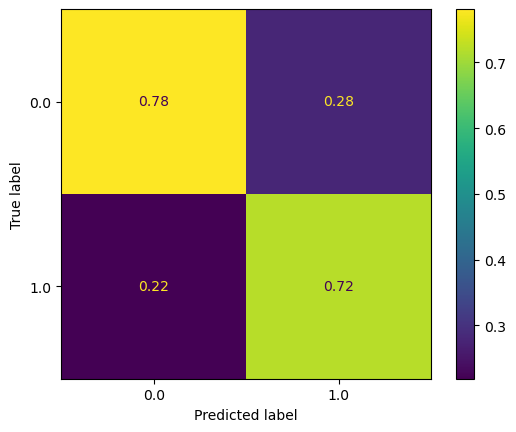

In [29]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, normalize = 'pred');

In [30]:
preds = rfc.predict(X_test)

In [31]:
confusion_matrix(y_test, preds).ravel()

array([371,  87, 104, 224])

In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(371, 87, 104, 224)

##### Metrics

In [33]:
accuracy = rfc.score(X_test, y_test)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Accuracy: ," , rfc.score(X_test, y_test))
print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Accuracy: , 0.7569974554707379
Specificity:  0.8100436681222707
Sensitivity:  0.6829268292682927
Precision:  0.7202572347266881
F1:  0.701095461658842


#### Discussion

Using a Random Forest Classifier with grid search led to improved scores on all metrics above. The F1 score remains above baseline, indicating that this model (using health-based variables) can be used to predict prevalence of diabetes in counties.

## II. Access (2010)

In [34]:
file_path = '../data/FoodEnvironmentAtlas.xls.ACCESS10_Modeling.csv'

access10 = pd.read_csv(file_path)

In [35]:
access10.head()

,fips,state,county,pct_laccess_pop10,pct_laccess_lowi10,pct_laccess_hhnv10,pct_laccess_child10,pct_laccess_seniors10,pct_diabetes18,class
0,1001,AL,Autauga,33.769657,9.793530,3.284786,8.837112,4.376378,9.5,1.0
1,1003,AL,Baldwin,19.318473,5.460261,2.147827,4.343199,3.513570,8.4,0.0
2,1005,AL,Barbour,20.840972,11.420316,4.135869,3.425062,2.805166,13.5,1.0
3,1007,AL,Bibb,4.559753,2.144661,3.458580,1.087518,0.657008,10.2,1.0
4,1009,AL,Blount,2.700840,1.062468,3.269380,0.671490,0.340269,10.5,1.0


In [36]:
access10.corr()

,fips,pct_laccess_pop10,pct_laccess_lowi10,pct_laccess_hhnv10,pct_laccess_child10,pct_laccess_seniors10,pct_diabetes18,class
fips,1.000000,0.042381,0.015372,-0.088925,0.038996,0.063841,-0.083778,-0.084537
pct_laccess_pop10,0.042381,1.000000,0.901990,0.120230,0.960288,0.919708,-0.134409,-0.137711
pct_laccess_lowi10,0.015372,0.901990,1.000000,0.278589,0.890427,0.826800,-0.031133,-0.067593
pct_laccess_hhnv10,-0.088925,0.120230,0.278589,1.000000,0.162575,0.043447,0.173692,0.110627
pct_laccess_child10,0.038996,0.960288,0.890427,0.162575,1.000000,0.823629,-0.086022,-0.103810
pct_laccess_seniors10,0.063841,0.919708,0.826800,0.043447,0.823629,1.000000,-0.190457,-0.185915
pct_diabetes18,-0.083778,-0.134409,-0.031133,0.173692,-0.086022,-0.190457,1.000000,0.799640
class,-0.084537,-0.137711,-0.067593,0.110627,-0.103810,-0.185915,0.799640,1.000000


### KNN Classification

#### 1. Create X and y

In [37]:
X = access10.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y= access10['class']

#### 2. Determine baseline accuracy

In [38]:
access10['class'].value_counts(normalize=True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

Baseline is 0.349.

#### 3. Scale features

In [39]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate model

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors= 7)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.7215619694397284 0.6157760814249363


#### 6. Generate predictions

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    knn_preds = knn.predict(X_test)

#### 7. Evaluate

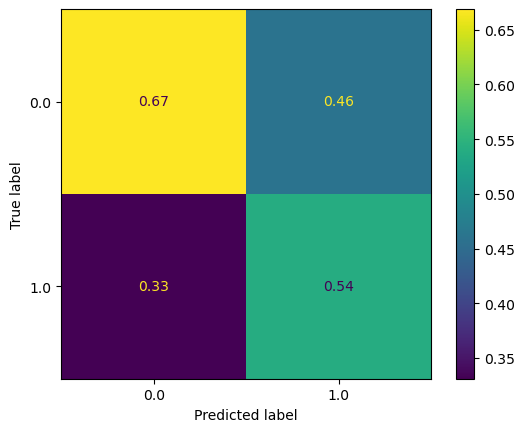

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [45]:
confusion_matrix(y_test, preds).ravel()

array([309, 149, 153, 175])

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [47]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(309, 149, 153, 175)

##### Accuracy (previously determined above)

In [48]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.6157760814249363


This the proportion of total predictions that are correct. The accuracy is 0.616, which is higher than baseline.

##### Specificity

In [49]:
specificity = tn / (tn + fp)

specificity

0.6746724890829694

This is the proportion of total negatives that were predicted correctly. The specificity score is 0.675.

##### Sensitivity

In [50]:
sensitivity = tp / (tp + fn)

sensitivity

0.5335365853658537

This is the proportion of total positives that were predicted correctly. The sensitivity score here of 0.534 would ideally be higher.

##### Precision

In [51]:
precision = tp / (tp + fp)

precision

0.5401234567901234

This is the proportion of predicted positives that are actually positives. Ideally, the score would be higher than the 0.540 seen here.

##### F1

In [52]:
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)

f1

0.5368098159509201

The F1 score combines the precicsion and sensitivity scores, and gives us an overall score through which to evaluate the model. Unfortunately, the model's score is below the baseline of 0.583.

#### Discussion

This model, which used data from 2010, did not effectively predict high or low prevalence of diabetes based on factors involving access to stores. Perhaps data collected closer to the time period of the target data would produce more predictive results.

## Access

In [53]:
file_path = '../data/FoodEnvironmentAtlas.xls.ACCESS_Modeling.csv'

access = pd.read_csv(file_path)

In [54]:
access.head()

,fips,state,county,pct_laccess_pop10,pct_laccess_pop15,pct_laccess_lowi10,pct_laccess_lowi15,pct_laccess_hhnv10,pct_laccess_hhnv15,pct_laccess_snap15,pct_laccess_child10,pct_laccess_child15,pct_laccess_seniors10,pct_laccess_seniors15,pct_diabetes18,class
0,1001,AL,Autauga,33.769657,32.062255,9.793530,11.991125,3.284786,3.351332,4.608749,8.837112,8.460485,4.376378,3.996279,9.5,1.0
1,1003,AL,Baldwin,19.318473,16.767489,5.460261,5.424427,2.147827,1.905114,1.298900,4.343199,3.844936,3.513570,3.061840,8.4,0.0
2,1005,AL,Barbour,20.840972,22.105560,11.420316,10.739667,4.135869,4.329378,4.303147,3.425062,3.758341,2.805166,3.001695,13.5,1.0
3,1007,AL,Bibb,4.559753,4.230324,2.144661,2.601627,3.458580,2.821427,0.676710,1.087518,1.015242,0.657008,0.600865,10.2,1.0
4,1009,AL,Blount,2.700840,6.497380,1.062468,2.880150,3.269380,3.336414,0.812727,0.671490,1.588720,0.340269,0.882583,10.5,1.0


In [55]:
access.corr()

,fips,pct_laccess_pop10,pct_laccess_pop15,pct_laccess_lowi10,pct_laccess_lowi15,pct_laccess_hhnv10,pct_laccess_hhnv15,pct_laccess_snap15,pct_laccess_child10,pct_laccess_child15,pct_laccess_seniors10,pct_laccess_seniors15,pct_diabetes18,class
fips,1.000000,0.044676,0.047202,0.017171,0.012524,-0.089955,-0.098144,-0.008702,0.041220,0.041755,0.065787,0.069672,-0.083215,-0.084746
pct_laccess_pop10,0.044676,1.000000,0.853414,0.901380,0.743295,0.122078,0.054158,0.469834,0.959989,0.807716,0.919354,0.794706,-0.136624,-0.141467
pct_laccess_pop15,0.047202,0.853414,1.000000,0.778225,0.902763,0.126787,0.149968,0.636900,0.822633,0.956227,0.766747,0.908728,-0.113586,-0.126183
pct_laccess_lowi10,0.017171,0.901380,0.778225,1.000000,0.818331,0.280986,0.210646,0.625093,0.889739,0.761005,0.825874,0.722729,-0.032367,-0.070412
pct_laccess_lowi15,0.012524,0.743295,0.902763,0.818331,1.000000,0.286250,0.325036,0.825737,0.738435,0.890612,0.652591,0.801443,0.004368,-0.040942
pct_laccess_hhnv10,-0.089955,0.122078,0.126787,0.280986,0.286250,1.000000,0.898404,0.469096,0.164697,0.167128,0.044491,0.042016,0.171463,0.110415
pct_laccess_hhnv15,-0.098144,0.054158,0.149968,0.210646,0.325036,0.898404,1.000000,0.529472,0.087083,0.179918,-0.010279,0.067063,0.183477,0.112943
pct_laccess_snap15,-0.008702,0.469834,0.636900,0.625093,0.825737,0.469096,0.529472,1.000000,0.514461,0.683914,0.350932,0.493608,0.160010,0.077076
pct_laccess_child10,0.041220,0.959989,0.822633,0.889739,0.738435,0.164697,0.087083,0.514461,1.000000,0.854632,0.822657,0.705932,-0.087828,-0.107267
pct_laccess_child15,0.041755,0.807716,0.956227,0.761005,0.890612,0.167128,0.179918,0.683914,0.854632,1.000000,0.666923,0.802065,-0.063638,-0.092573


### KNN Classification

#### 1. Create X and y

In [56]:
X = access.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = access['class']

#### 2. Determine baseline

In [57]:
access['class'].value_counts(normalize = True)

0.0    0.581492
1.0    0.418508
Name: class, dtype: float64

Baseline is 0.581.

#### 3. Scale features

In [58]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, and evaluate the model

In [60]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)
    
# Instantiate
    knn = KNeighborsClassifier(n_neighbors= 24)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.6912894961571306 0.6325224071702945


#### 6. Evaluate

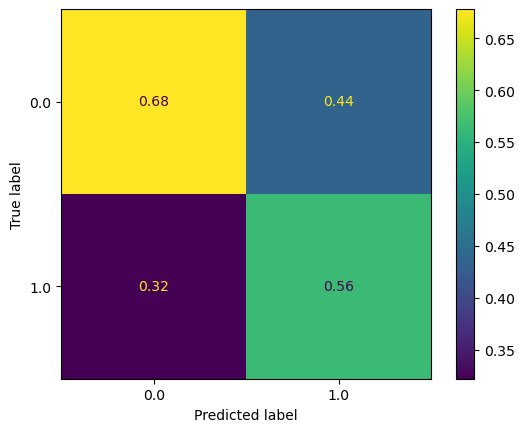

In [61]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [62]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [63]:
confusion_matrix(y_test, preds).ravel()

array([318, 136, 151, 176])

In [64]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [65]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(318, 136, 151, 176)

##### Accuracy

In [66]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.6325224071702945


This is the proportion of total predictions that were correct. The score of 0.633 is above the baseline (which was 0.583.) 


##### Specificity

In [67]:
specificity = tn / (tn + fp)

specificity


0.7004405286343612

This is the proportion of total negatives that were predicted correctly. As far as the current study, the score of 0.700 is relatively high.

##### Sensitivity

In [68]:
sensitivity = tp / (tp + fn)

sensitivity

0.5382262996941896

This is the proportion of total positives that were predicted correctly. The sensitivity score here of 0.538 would ideally be higher.

In [69]:
precision = tp / (tp + fp)

precision


0.5641025641025641

This is the proportion of predicted positives that are actually positives. Ideally, the score would be higher than the 0.564 seen here.

##### F1

In [70]:
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)

f1

0.5508607198748043

The F1 score combines the precicsion and sensitivity scores, and gives us an overall score through which to evaluate the model. Unfortunately, the model's score is below the baseline of 0.581.

## Assistance

In [71]:
file_path = '../data/FoodEnvironmentAtlas.xls.ASSISTANCE_Modeling.csv'

assistance = pd.read_csv(file_path)

In [72]:
assistance.head()

,fips,state,county,pct_snap12,pct_snap17,snap_part_rate11,snap_part_rate16,pct_nslp12,pct_nslp17,pct_sbp12,...,pct_wicinfantchild16,pct_wicwomen14,pct_wicwomen16,pct_cacfp12,pct_cacfp17,fdpir12,fdpir15,food_banks18,pct_diabetes18,class
0,1001,AL,Autauga,18.908476,16.500056,84.02,86.898,68.226043,63.12659,27.206328,...,32.910876,3.318827,3.309759,0.891239,1.258763,0,0,0,9.5,1.0
1,1003,AL,Baldwin,18.908476,16.500056,84.02,86.898,68.226043,63.12659,27.206328,...,32.910876,3.318827,3.309759,0.891239,1.258763,0,0,0,8.4,0.0
2,1005,AL,Barbour,18.908476,16.500056,84.02,86.898,68.226043,63.12659,27.206328,...,32.910876,3.318827,3.309759,0.891239,1.258763,0,0,0,13.5,1.0
3,1007,AL,Bibb,18.908476,16.500056,84.02,86.898,68.226043,63.12659,27.206328,...,32.910876,3.318827,3.309759,0.891239,1.258763,0,0,0,10.2,1.0
4,1009,AL,Blount,18.908476,16.500056,84.02,86.898,68.226043,63.12659,27.206328,...,32.910876,3.318827,3.309759,0.891239,1.258763,0,0,0,10.5,1.0


In [73]:
assistance.corr()

,fips,pct_snap12,pct_snap17,snap_part_rate11,snap_part_rate16,pct_nslp12,pct_nslp17,pct_sbp12,pct_sbp17,pct_wic12,...,pct_wicinfantchild16,pct_wicwomen14,pct_wicwomen16,pct_cacfp12,pct_cacfp17,fdpir12,fdpir15,food_banks18,pct_diabetes18,class
fips,1.000000,-0.065836,-0.024371,0.095117,0.012169,0.012683,-0.012620,0.072848,0.032185,-0.096930,...,-0.158105,-0.010247,-0.033690,0.058130,0.090656,-0.041026,-0.039256,-0.064933,-0.083778,-0.084537
pct_snap12,-0.065836,1.000000,0.899788,0.590054,0.413769,0.162293,0.174770,0.699636,0.670335,0.442245,...,0.651738,0.508047,0.521729,-0.231417,-0.065182,-0.014038,-0.008983,0.003890,0.340205,0.295504
pct_snap17,-0.024371,0.899788,1.000000,0.416246,0.467602,0.115223,0.160991,0.672529,0.670124,0.456017,...,0.647687,0.502725,0.531860,-0.142570,0.034026,0.016961,0.019590,0.035177,0.298066,0.261004
snap_part_rate11,0.095117,0.590054,0.416246,1.000000,0.724734,-0.120176,-0.107168,0.027750,0.023506,-0.203255,...,0.082773,-0.127578,-0.138246,-0.315755,-0.412990,-0.053537,-0.052754,-0.015711,0.098802,0.072936
snap_part_rate16,0.012169,0.413769,0.467602,0.724734,1.000000,-0.350059,-0.298113,-0.162272,-0.090308,-0.302008,...,0.064593,-0.253558,-0.255669,-0.277594,-0.417987,-0.027869,-0.023757,0.049047,0.031606,0.022534
pct_nslp12,0.012683,0.162293,0.115223,-0.120176,-0.350059,1.000000,0.980218,0.525948,0.455802,0.275249,...,0.158656,0.322004,0.351336,0.608529,0.615432,-0.079195,-0.082215,-0.156954,0.139776,0.096602
pct_nslp17,-0.012620,0.174770,0.160991,-0.107168,-0.298113,0.980218,1.000000,0.525543,0.481496,0.277652,...,0.201660,0.321451,0.352929,0.614057,0.636005,-0.065767,-0.068455,-0.136452,0.152817,0.106235
pct_sbp12,0.072848,0.699636,0.672529,0.027750,-0.162272,0.525948,0.525543,1.000000,0.938356,0.707665,...,0.646858,0.776889,0.780938,0.099363,0.388383,-0.022657,-0.022979,-0.063133,0.268517,0.226464
pct_sbp17,0.032185,0.670335,0.670124,0.023506,-0.090308,0.455802,0.481496,0.938356,1.000000,0.604882,...,0.637767,0.665698,0.687573,0.047400,0.323816,-0.028168,-0.029278,-0.047754,0.302243,0.265341
pct_wic12,-0.096930,0.442245,0.456017,-0.203255,-0.302008,0.275249,0.277652,0.707665,0.604882,1.000000,...,0.803883,0.952579,0.932442,0.104504,0.459863,0.088728,0.094273,0.058988,0.102278,0.080138


## KNN Classification

#### 1. Create X and y

In [74]:
X = assistance.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = assistance['class']

#### 2. Determine baseline

In [75]:
assistance['class'].value_counts(normalize=True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

#### 3. Scale features

In [76]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

#### 5. Instantiate, fit, evaluate model

In [78]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors= 7)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.7279286926994907 0.6908396946564885


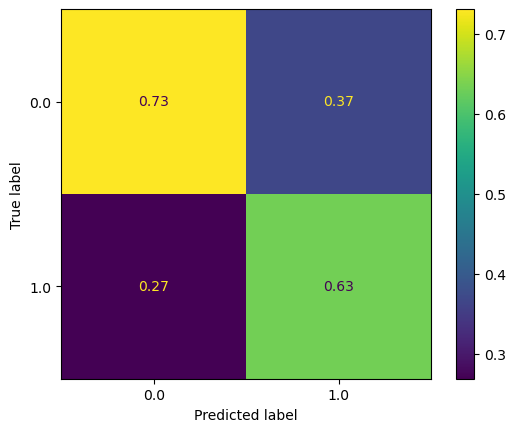

In [79]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [80]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [81]:
confusion_matrix(y_test, preds).ravel()

array([340, 118, 125, 203])

In [82]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [83]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(340, 118, 125, 203)

##### Accuracy (pre-determined above)

In [84]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))


0.6908396946564885


##### Additional Metrics

In [85]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.74235807860262
Sensitivity:  0.6189024390243902
Precision:  0.632398753894081
F1:  0.6255778120184899


Again, the specificity is higher than the sensitivity. Still, at 0.619, the sensitivity is high enough to combine with precision to create an F1 score (0.626) that exceeds baseline.

It appears that the Assistance variables, including information about public benefits, food banks, and so on, can be used to predict high or low prevalence of diabetes in counties.

## Insecurity

In [86]:
file_path = '../data/FoodEnvironmentAtlas.xls.INSECURITY_Modeling.csv'

insecurity = pd.read_csv(file_path)

In [87]:
insecurity.head()

,fips,state,county,foodinsec_12_14,foodinsec_15_17,ch_foodinsec_14_17,vlfoodsec_12_14,vlfoodsec_15_17,ch_vlfoodsec_14_17,pct_diabetes18,class
0,1001,AL,Autauga,16.8,16.3,-0.5,7.2,7.1,-0.1,9.5,1.0
1,1003,AL,Baldwin,16.8,16.3,-0.5,7.2,7.1,-0.1,8.4,0.0
2,1005,AL,Barbour,16.8,16.3,-0.5,7.2,7.1,-0.1,13.5,1.0
3,1007,AL,Bibb,16.8,16.3,-0.5,7.2,7.1,-0.1,10.2,1.0
4,1009,AL,Blount,16.8,16.3,-0.5,7.2,7.1,-0.1,10.5,1.0


In [88]:
insecurity.corr()

,fips,foodinsec_12_14,foodinsec_15_17,ch_foodinsec_14_17,vlfoodsec_12_14,vlfoodsec_15_17,ch_vlfoodsec_14_17,pct_diabetes18,class
fips,1.000000,-0.038613,-0.056442,-0.013781,-0.062002,-0.020681,0.047586,-0.083778,-0.084537
foodinsec_12_14,-0.038613,1.000000,0.761057,-0.547192,0.856936,0.736792,-0.076648,0.068574,0.050881
foodinsec_15_17,-0.056442,0.761057,1.000000,0.126510,0.648272,0.928311,0.419945,0.104409,0.086580
ch_foodinsec_14_17,-0.013781,-0.547192,0.126510,1.000000,-0.473948,0.071115,0.659070,0.029856,0.033909
vlfoodsec_12_14,-0.062002,0.856936,0.648272,-0.473948,1.000000,0.678575,-0.322943,0.184652,0.155868
vlfoodsec_15_17,-0.020681,0.736792,0.928311,0.071115,0.678575,1.000000,0.476032,0.088081,0.074817
ch_vlfoodsec_14_17,0.047586,-0.076648,0.419945,0.659070,-0.322943,0.476032,1.000000,-0.107588,-0.090216
pct_diabetes18,-0.083778,0.068574,0.104409,0.029856,0.184652,0.088081,-0.107588,1.000000,0.799640
class,-0.084537,0.050881,0.086580,0.033909,0.155868,0.074817,-0.090216,0.799640,1.000000


### KNN Classification

#### 1. Create X and y

In [89]:
X = insecurity.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = insecurity['class']

#### 2. Determine baseline

In [90]:
insecurity['class'].value_counts(normalize = True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

Baseline is 0.583.

#### 3. Scale features

In [91]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, and evaluate

In [93]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors= 7)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.719439728353141 0.6997455470737913


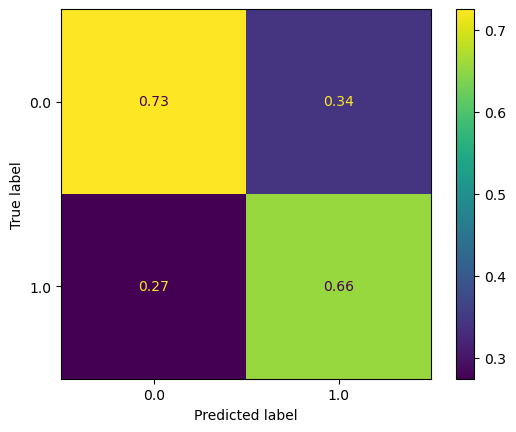

In [94]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [95]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)
    
    preds = knn.predict(X_test) #generates predictions

In [96]:
confusion_matrix(y_test, preds).ravel()

array([357, 101, 135, 193])

In [97]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(340, 118, 125, 203)

##### Accuracy (pre-determined above)

In [98]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))


0.6997455470737913


This is the proportion of total predictions that were correct. 

##### Additional Metrics

In [99]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.74235807860262
Sensitivity:  0.6189024390243902
Precision:  0.632398753894081
F1:  0.6255778120184899


##### Discussion

The F1 score is above baseline, suggesting that this model can be used to a certain degree to predict prevalence of diabetes using food insecurity.

## Local - Farmer's Market - Payment

In [100]:
file_path = '../data/FoodEnvironmentAtlas.xls.LOCAL_Modeling_FrmrktP.csv'

local_fmp = pd.read_csv(file_path)

In [101]:
local_fmp.head()

,fips,state,county,fmrkt13,fmrkt18,fmrktpth13,fmrktpth18,fmrkt_snap18,pct_fmrkt_snap18,fmrkt_wic18,pct_fmrkt_wic18,fmrkt_wiccash18,pct_fmrkt_wiccash18,fmrkt_sfmnp18,pct_fmrkt_sfmnp18,fmrkt_credit18,pct_fmrkt_credit18,pct_diabetes18,class
0,1001,AL,Autauga,1.0,1.0,0.018277,0.017985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.5,1.0
1,1003,AL,Baldwin,4.0,4.0,0.020525,0.018347,0.0,0.0,0.0,0.0,0.0,0.0,4.0,100.0,2.0,50.0,8.4,0.0
2,1005,AL,Barbour,3.0,4.0,0.111342,0.160765,2.0,50.0,0.0,0.0,0.0,0.0,2.0,50.0,2.0,50.0,13.5,1.0
3,1007,AL,Bibb,1.0,1.0,0.044413,0.044643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,1.0
4,1009,AL,Blount,1.0,1.0,0.017358,0.017289,0.0,0.0,1.0,100.0,0.0,0.0,1.0,100.0,0.0,0.0,10.5,1.0


In [102]:
local_fmp.corr()

,fips,fmrkt13,fmrkt18,fmrktpth13,fmrktpth18,fmrkt_snap18,pct_fmrkt_snap18,fmrkt_wic18,pct_fmrkt_wic18,fmrkt_wiccash18,pct_fmrkt_wiccash18,fmrkt_sfmnp18,pct_fmrkt_sfmnp18,fmrkt_credit18,pct_fmrkt_credit18,pct_diabetes18,class
fips,1.000000,-0.064896,-0.064521,0.010376,-0.010518,-0.043122,0.005278,-0.038357,-0.022642,-0.019658,-0.009443,-0.038578,-0.029703,-0.044176,0.016178,-0.084269,-0.085095
fmrkt13,-0.064896,1.000000,0.982315,0.042276,0.007840,0.863959,0.198284,0.770162,0.227590,0.659893,0.156866,0.789742,0.179823,0.915505,0.202214,-0.011735,0.013676
fmrkt18,-0.064521,0.982315,1.000000,0.022077,0.017971,0.890982,0.210496,0.805827,0.229237,0.693473,0.157372,0.822833,0.182496,0.945125,0.228749,-0.008823,0.014474
fmrktpth13,0.010376,0.042276,0.022077,1.000000,0.821297,-0.023195,0.000799,-0.006913,0.063429,-0.000172,0.066867,-0.003692,0.086102,-0.027752,0.011829,-0.142234,-0.126007
fmrktpth18,-0.010518,0.007840,0.017971,0.821297,1.000000,-0.024859,0.016888,-0.014503,0.048088,-0.005978,0.053150,-0.007543,0.077718,-0.022835,0.068773,-0.139789,-0.122163
fmrkt_snap18,-0.043122,0.863959,0.890982,-0.023195,-0.024859,1.000000,0.377634,0.882219,0.282937,0.752915,0.200157,0.897440,0.235160,0.926167,0.255734,-0.005570,0.004265
pct_fmrkt_snap18,0.005278,0.198284,0.210496,0.000799,0.016888,0.377634,1.000000,0.252225,0.425053,0.221067,0.345934,0.255549,0.423707,0.285141,0.589652,0.087393,0.099007
fmrkt_wic18,-0.038357,0.770162,0.805827,-0.006913,-0.014503,0.882219,0.252225,1.000000,0.430175,0.818606,0.249730,0.941715,0.306525,0.821152,0.193343,-0.014262,-0.008709
pct_fmrkt_wic18,-0.022642,0.227590,0.229237,0.063429,0.048088,0.282937,0.425053,0.430175,1.000000,0.308641,0.465882,0.364767,0.678735,0.255302,0.344950,0.044540,0.064511
fmrkt_wiccash18,-0.019658,0.659893,0.693473,-0.000172,-0.005978,0.752915,0.221067,0.818606,0.308641,1.000000,0.429310,0.807422,0.264310,0.708364,0.171278,-0.008831,-0.000391


### KNN Classification

#### 1. Create X and y

In [103]:
X = local_fmp.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = local_fmp['class']

#### 2. Determine baseline

In [104]:
local_fmp['class'].value_counts(normalize = True)

0.0    0.582617
1.0    0.417383
Name: class, dtype: float64

Baseline is 0.583.

#### 3. Scale features

In [105]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, evaluate model

In [107]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 17)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.6530785562632696 0.6653944020356234


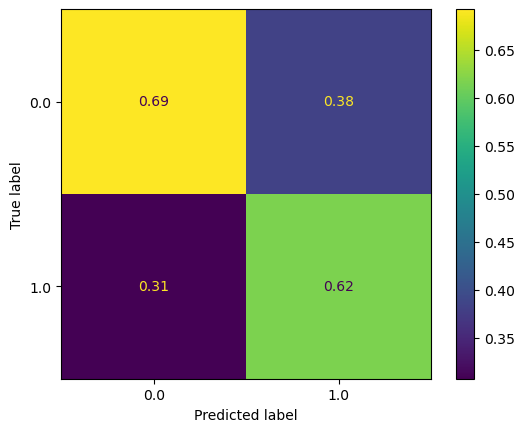

In [108]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [109]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions


In [110]:
confusion_matrix(y_test, preds).ravel()

array([351, 107, 156, 172])

In [111]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(351, 107, 156, 172)

##### Accuracy

In [112]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.6653944020356234


This is the proportion of total predictions that were correct. The score of 0.665 is above the baseline (which was 0.583.) 

In [113]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.7663755458515283
Sensitivity:  0.524390243902439
Precision:  0.6164874551971327
F1:  0.5667215815485998


#### Discussion

This is the only model created that uses predictor data from 2018, which matches the target data. Specificity is fairly high at 0.766. Just as in all previous models, sensitivity is lower at 0.524. While the accuracy score is above baseline, the F1 score is not, suggesting that overall, this model cannot effectively be used to predict prevalence of diabetes in counties.

## Farmer's Markets - Foods

In [114]:
file_path = '../data/FoodEnvironmentAtlas.xls.LOCAL_Modeling_FrmrktF.csv'

local_fmf = pd.read_csv(file_path)

In [115]:
local_fmf.head()

,fips,state,county,fmrkt_frveg18,pct_fmrkt_frveg18,fmrkt_anmlprod18,pct_fmrkt_anmlprod18,fmrkt_baked18,pct_fmrkt_baked18,fmrkt_otherfood18,pct_fmrkt_otherfood18,pct_diabetes18,class
0,1001,AL,Autauga,1.0,100.0,0.0,0.0,1.0,100.0,1.0,100.0,9.5,1.0
1,1003,AL,Baldwin,3.0,75.0,4.0,100.0,3.0,75.0,3.0,75.0,8.4,0.0
2,1005,AL,Barbour,2.0,50.0,0.0,0.0,2.0,50.0,2.0,50.0,13.5,1.0
3,1007,AL,Bibb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,1.0
4,1009,AL,Blount,1.0,100.0,1.0,100.0,1.0,100.0,1.0,100.0,10.5,1.0


In [116]:
local_fmf.corr()

,fips,fmrkt_frveg18,pct_fmrkt_frveg18,fmrkt_anmlprod18,pct_fmrkt_anmlprod18,fmrkt_baked18,pct_fmrkt_baked18,fmrkt_otherfood18,pct_fmrkt_otherfood18,pct_diabetes18,class
fips,1.000000,-0.046552,-0.022577,-0.036520,0.022439,-0.048480,-0.011937,-0.044779,-0.012988,-0.084269,-0.085095
fmrkt_frveg18,-0.046552,1.000000,0.325315,0.972522,0.286643,0.985173,0.301507,0.978605,0.297266,-0.009251,0.008945
pct_fmrkt_frveg18,-0.022577,0.325315,1.000000,0.323371,0.881300,0.326062,0.931402,0.333000,0.945291,0.087403,0.107022
fmrkt_anmlprod18,-0.036520,0.972522,0.323371,1.000000,0.337224,0.984152,0.315571,0.989712,0.312699,-0.025192,-0.001922
pct_fmrkt_anmlprod18,0.022439,0.286643,0.881300,0.337224,1.000000,0.302499,0.874917,0.310236,0.881012,0.044859,0.077123
fmrkt_baked18,-0.048480,0.985173,0.326062,0.984152,0.302499,1.000000,0.331532,0.988419,0.312487,-0.021024,0.000696
pct_fmrkt_baked18,-0.011937,0.301507,0.931402,0.315571,0.874917,0.331532,1.000000,0.323463,0.933550,0.054235,0.077147
fmrkt_otherfood18,-0.044779,0.978605,0.333000,0.989712,0.310236,0.988419,0.323463,1.000000,0.332290,-0.017419,0.004156
pct_fmrkt_otherfood18,-0.012988,0.297266,0.945291,0.312699,0.881012,0.312487,0.933550,0.332290,1.000000,0.070930,0.091617
pct_diabetes18,-0.084269,-0.009251,0.087403,-0.025192,0.044859,-0.021024,0.054235,-0.017419,0.070930,1.000000,0.799601


Although the years of the target value and most of this dataset match, the correlation between prevalence of diabetes as shown here is much lower than when the 2013 values, which were a part of the Food Environment Atlas, were used.

#### 1. Create X and y

In [117]:
X = local_fmf.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = local_fmf['class']

#### 2. Determine baseline

In [118]:
local_fmf['class'].value_counts(normalize = True)

0.0    0.582617
1.0    0.417383
Name: class, dtype: float64

Baseline is 0.583.

#### 3. Scale features

In [119]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, evaluate

In [121]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 15)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.6033970276008492 0.6043256997455471


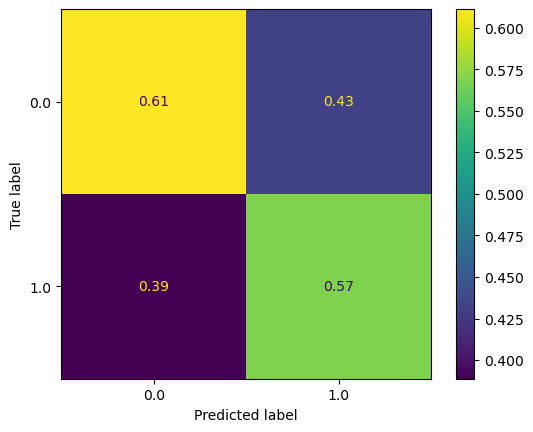

In [122]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [123]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [124]:
confusion_matrix(y_test, preds).ravel()

array([404,  54, 257,  71])

In [125]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(404, 54, 257, 71)

##### Accuracy

In [126]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.6043256997455471


##### Additional metrics

In [127]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.8820960698689956
Sensitivity:  0.21646341463414634
Precision:  0.568
F1:  0.31346578366445915


#### Discussion

While the accuracy, or overall rate of correct predictions is 0.604, the low sensitivity and precision scores create a low F1 score at 0.313.

This model failed to effectively predict high or low prevalence of diabetes in counties.

## Restaurants

In [128]:
file_path = ('../data/FoodEnvironmentAtlas.xls.RESTAURANTS_Modeling.csv')

restaurants = pd.read_csv(file_path)

In [129]:
restaurants.head()

,fips,state,county,ffr11,ffr16,ffrpth11,ffrpth16,fsr11,fsr16,fsrpth11,fsrpth16,pc_ffrsales07,pc_ffrsales12,pc_fsrsales07,pc_fsrsales12,pct_diabetes18,class
0,1001,AL,Autauga,34,44,0.615953,0.795977,32,31,0.579721,0.560802,649.511367,674.80272,484.381507,512.280987,9.5,1.0
1,1003,AL,Baldwin,121,156,0.648675,0.751775,216,236,1.157966,1.137300,649.511367,674.80272,484.381507,512.280987,8.4,0.0
2,1005,AL,Barbour,19,23,0.694673,0.892372,17,14,0.621549,0.543183,649.511367,674.80272,484.381507,512.280987,13.5,1.0
3,1007,AL,Bibb,6,7,0.263794,0.309283,5,7,0.219829,0.309283,649.511367,674.80272,484.381507,512.280987,10.2,1.0
4,1009,AL,Blount,20,23,0.347451,0.399569,15,12,0.260589,0.208471,649.511367,674.80272,484.381507,512.280987,10.5,1.0


In [130]:
restaurants.corr()

,fips,ffr11,ffr16,ffrpth11,ffrpth16,fsr11,fsr16,fsrpth11,fsrpth16,pc_ffrsales07,pc_ffrsales12,pc_fsrsales07,pc_fsrsales12,pct_diabetes18,class
fips,1.000000,-0.048146,-0.050784,0.062618,0.052454,-0.052690,-0.050941,0.035546,0.049219,0.046978,0.029869,-0.012558,0.046849,-0.083778,-0.084537
ffr11,-0.048146,1.000000,0.998708,0.168785,0.179611,0.974328,0.977887,-0.003491,0.014214,0.045710,-0.028006,0.150684,0.170639,0.035731,0.052164
ffr16,-0.050784,0.998708,1.000000,0.160782,0.176991,0.971885,0.975939,-0.004206,0.012611,0.050873,-0.021006,0.148485,0.166465,0.033664,0.049865
ffrpth11,0.062618,0.168785,0.160782,1.000000,0.841815,0.168807,0.165711,0.387793,0.400447,0.102388,0.056905,0.114904,0.111655,0.031197,0.055297
ffrpth16,0.052454,0.179611,0.176991,0.841815,1.000000,0.181560,0.177318,0.354601,0.352283,0.110794,0.081774,0.091191,0.085421,0.064640,0.078264
fsr11,-0.052690,0.974328,0.971885,0.168807,0.181560,1.000000,0.998644,0.039930,0.057712,0.027764,-0.064144,0.169761,0.197033,0.002134,0.022614
fsr16,-0.050941,0.977887,0.975939,0.165711,0.177318,0.998644,1.000000,0.035307,0.056703,0.031696,-0.058916,0.170381,0.196276,0.001985,0.023014
fsrpth11,0.035546,-0.003491,-0.004206,0.387793,0.354601,0.039930,0.035307,1.000000,0.895938,-0.080765,-0.181403,0.145395,0.169245,-0.268432,-0.219609
fsrpth16,0.049219,0.014214,0.012611,0.400447,0.352283,0.057712,0.056703,0.895938,1.000000,-0.098219,-0.213586,0.154553,0.178681,-0.273591,-0.218704
pc_ffrsales07,0.046978,0.045710,0.050873,0.102388,0.110794,0.027764,0.031696,-0.080765,-0.098219,1.000000,0.805304,0.498485,0.290445,0.005859,0.017653


### KNN Classification

#### 1. Create X and y

In [131]:
X = restaurants.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = restaurants['class']

#### 2. Determine baseline

In [132]:
restaurants['class'].value_counts(normalize = True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

#### 3. Scale features

In [133]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, evaluate

In [135]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 14)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.7529711375212224 0.7290076335877863


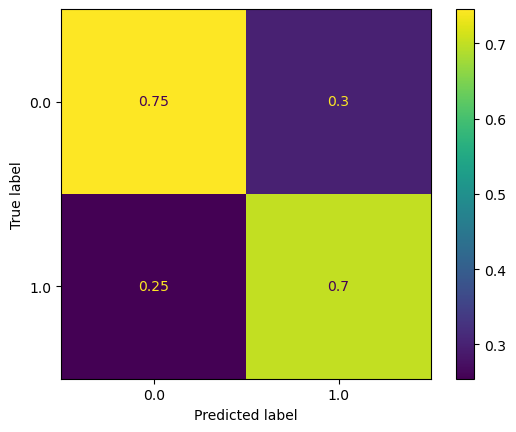

In [136]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [137]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [138]:
confusion_matrix(y_test, preds).ravel()



array([372,  86, 127, 201])

In [139]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()



In [140]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(372, 86, 127, 201)

##### Accuracy

In [141]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.7290076335877863


##### Additional metrics

In [142]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.8122270742358079
Sensitivity:  0.6128048780487805
Precision:  0.7003484320557491
F1:  0.6536585365853659


##### Discussion

In this model, specificity was high at 0.812. Sensitivity, while still lower at 0.612, is higher than in previous models in this study. When combined with precision, the generated F1 score is 0.654, which exceeds baseline. This suggests that the numbers of each types of restaurant, and how much residents spend at them, can be used to predict prevalence of diabetes within counties.

Because the Restaurants dataset is shown to have predictive power, I will use Random Forest Classification with Grid Search in order to maximize its predictive power.

### Random Forest Classification

#### 1. Instantiate & fit the model

In [143]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 2. Generate initial score

In [144]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9995755517826825, 0.7353689567430025)

There is a great deal of overfit, but the accuracy score is 0.735.

#### 3. Grid search for best parameters

In [145]:
grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 6789),
                    param_grid = {'max_depth': [2, 8, 12, 16],
                                  'n_estimators':[20, 80, 120, 240],
                                 'min_samples_split': [2, 4, 6, 8],
                                 'min_samples_leaf': [2, 3, 4, 5, 6]},
                    
                                  cv=5, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=6789),
             param_grid={'max_depth': [2, 8, 12, 16],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [20, 80, 120, 240]},
             verbose=1)

In [146]:
grid.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=4, n_estimators=240,
                       random_state=6789)

*Estimator shown above leads to an F1 score of 0.672. A previous grid search led to a higher F1 score under the following parameters:*

**max depth = 12, min_samples leaf = 5, min_samples split = 8, n_estimators = 240, random_state = 6789** 


**These parameters will be used in order to maximize the F1 score.**

#### 4. Instantiate & fit with new parameters

In [147]:
rfc = RandomForestClassifier(max_depth=12, min_samples_leaf=5, min_samples_split = 8, n_estimators=240,
                       random_state=6789)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=5, min_samples_split=8,
                       n_estimators=240, random_state=6789)

#### 5. Evaluate

In [148]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.879881154499151, 0.7417302798982188)

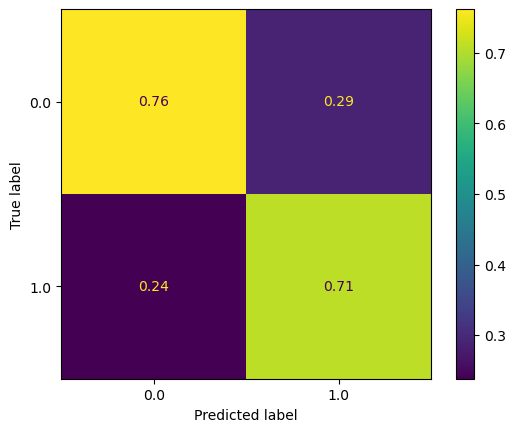

In [149]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, normalize = 'pred');

In [150]:
preds = rfc.predict(X_test)

In [151]:
confusion_matrix(y_test, preds).ravel()

array([371,  87, 116, 212])

In [152]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(371, 87, 116, 212)

##### Metrics

In [153]:
accuracy = rfc.score(X_test, y_test)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Accuracy: ," , rfc.score(X_test, y_test))
print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)


Accuracy: , 0.7417302798982188
Specificity:  0.8100436681222707
Sensitivity:  0.6463414634146342
Precision:  0.7090301003344481
F1:  0.6762360446570972


### Discussion

The Random Forest Classifier, fit with the best hyperparameters following a Grid Search, led to an increased F1 score of 0.676 (0.654 using KNN.) These findings confirm that the Restaurants dataset can be used to predict prevalence of diabetes in counties.

## Socioeconomic

In [154]:
file_path = '../data/FoodEnvironmentAtlas.xls.SOCIOECONOMIC_Modeling.csv'

sec = pd.read_csv(file_path)

In [155]:
sec.head()

,fips,state,county,pct_65older10,pct_18younger10,medhhinc15,povrate15,perpov10,childpovrate15,perchldpov10,metro13,poploss10,pct_diabetes18,class
0,1001,AL,Autauga,11.995382,26.777959,56580.0,12.7,0,18.8,0,1,0.0,9.5,1.0
1,1003,AL,Baldwin,16.771185,22.987408,52387.0,12.9,0,19.6,0,1,0.0,8.4,0.0
2,1005,AL,Barbour,14.236807,21.906982,31433.0,32.0,1,45.2,1,0,0.0,13.5,1.0
3,1007,AL,Bibb,12.681650,22.696923,40767.0,22.2,0,29.3,1,1,0.0,10.2,1.0
4,1009,AL,Blount,14.722096,24.608353,50487.0,14.7,0,22.2,0,1,0.0,10.5,1.0


In [156]:
sec.corr()

,fips,pct_65older10,pct_18younger10,medhhinc15,povrate15,perpov10,childpovrate15,perchldpov10,metro13,poploss10,pct_diabetes18,class
fips,1.000000,0.075028,-0.037885,0.068247,-0.119573,-0.076247,-0.125123,-0.072814,0.001259,-0.015492,-0.086405,-0.085816
pct_65older10,0.075028,1.000000,-0.524088,-0.291583,-0.074526,-0.105146,0.069784,-0.037954,-0.393456,0.356602,-0.229171,-0.213884
pct_18younger10,-0.037885,-0.524088,1.000000,0.145593,-0.008683,0.113820,-0.009211,0.101100,0.128559,-0.098572,0.164118,0.117197
medhhinc15,0.068247,-0.291583,0.145593,1.000000,-0.783640,-0.419987,-0.814689,-0.493237,0.398813,-0.117775,-0.296772,-0.217528
povrate15,-0.119573,-0.074526,-0.008683,-0.783640,1.000000,0.646645,0.938094,0.674762,-0.217190,0.006335,0.408704,0.299918
perpov10,-0.076247,-0.105146,0.113820,-0.419987,0.646645,1.000000,0.604077,0.641734,-0.163774,0.042797,0.261195,0.173258
childpovrate15,-0.125123,0.069784,-0.009211,-0.814689,0.938094,0.604077,1.000000,0.678418,-0.241876,0.015399,0.390596,0.293059
perchldpov10,-0.072814,-0.037954,0.101100,-0.493237,0.674762,0.641734,0.678418,1.000000,-0.176925,0.022465,0.279556,0.201714
metro13,0.001259,-0.393456,0.128559,0.398813,-0.217190,-0.163774,-0.241876,-0.176925,1.000000,-0.236638,0.114235,0.129459
poploss10,-0.015492,0.356602,-0.098572,-0.117775,0.006335,0.042797,0.015399,0.022465,-0.236638,1.000000,-0.052658,-0.075536


These appear to be the most strongly correlated with diabetes prevalence & class than any of the others. 

We will see how the model will perform.

### KNN Classification

#### 1. Create X and y

In [157]:
X = sec.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = sec['class']

#### 2. Determine baseline

In [158]:
sec['class'].value_counts(normalize = True)

0.0    0.58267
1.0    0.41733
Name: class, dtype: float64

Baseline is 0.583. 

#### 3. Scale features

In [159]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, evaluate

In [161]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 20)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.7230246389124894 0.6802547770700637


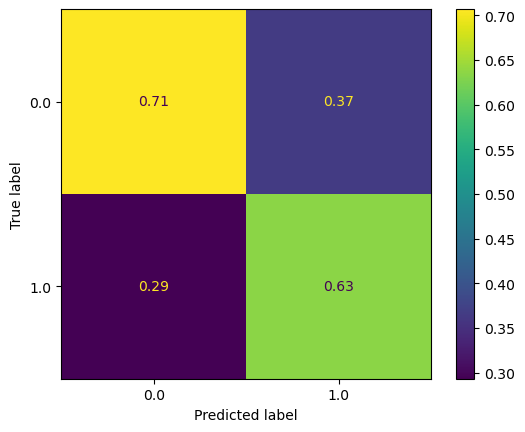

In [162]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [163]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [164]:
confusion_matrix(y_test, preds).ravel()

array([352, 105, 146, 182])

In [165]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(352, 105, 146, 182)

##### Accuracy (pre-determined above)

In [166]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    print(knn.score(X_test, y_test))

0.6802547770700637


##### Additional Metrics

In [167]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.7702407002188184
Sensitivity:  0.5548780487804879
Precision:  0.6341463414634146
F1:  0.5918699186991871


##### Discussion

The combined precision and sensitivity are enough to create an F1 score of 0.592, which just barely exceeds baseline. 

Overall, this model is not so effective at predicting prevalence of diabetes in counties.

## Stores - Convenience & Specialized

In [168]:
file_path = '../data/FoodEnvironmentAtlas.xls.STORES_Modeling_ConSpec.csv'

stores_cs = pd.read_csv(file_path)

In [169]:
stores_cs.head()

,fips,state,county,convs11,convs16,convspth11,convspth16,specs11,specs16,specspth11,specspth16,pct_diabetes18,class
0,1001,AL,Autauga,31,31,0.561604,0.560802,1,1,0.018116,0.018090,9.5,1.0
1,1003,AL,Baldwin,107,118,0.573622,0.568650,20,27,0.107219,0.130115,8.4,0.0
2,1005,AL,Barbour,22,19,0.804358,0.737177,3,2,0.109685,0.077598,13.5,1.0
3,1007,AL,Bibb,19,15,0.835348,0.662749,0,0,0.000000,0.000000,10.2,1.0
4,1009,AL,Blount,30,27,0.521177,0.469059,1,0,0.017373,0.000000,10.5,1.0


### KNN Classification

#### 1. Create X and y

In [170]:
X = stores_cs.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = stores_cs['class']

#### 2. Determine baseline

In [171]:
stores_cs['class'].value_counts(normalize = True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

Baseline is 0.583.

#### 3. Scale features

In [172]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, evaluate

In [174]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 25)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.6786926994906621 0.6564885496183206


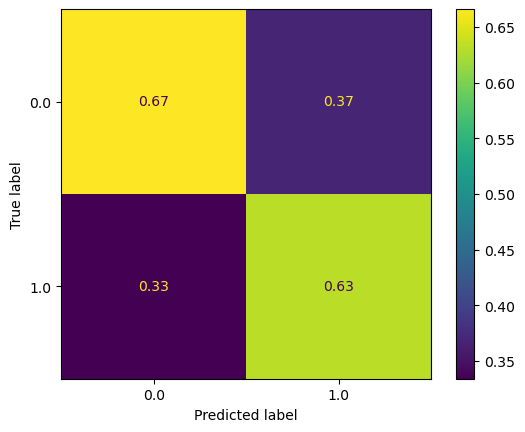

In [175]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [176]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions



In [177]:
confusion_matrix(y_test, preds).ravel()

array([377,  81, 189, 139])

In [178]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(377, 81, 189, 139)

##### Accuracy (pre-determined above)

In [179]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)
    
    print(knn.score(X_test, y_test))

0.6564885496183206


##### Additional metrics

In [180]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.8231441048034934
Sensitivity:  0.42378048780487804
Precision:  0.6318181818181818
F1:  0.5072992700729927


While the specificity is high at 0.823, the sensitivity is low at only 0.424. The precision and sensitivity scores combine to create an F1 score that is below baseline.

This model cannot be used effectively in order to predict prevalence of diabetes in counties.

## Stores - SNAP & WIC

In [181]:
file_path = ('../data/FoodEnvironmentAtlas.xls.STORES_Modeling_SnapWic.csv')

stores_sw = pd.read_csv(file_path)

In [182]:
stores_sw.head()

,fips,state,county,snaps12,snaps17,snapspth12,snapspth17,wics11,wics16,wicspth11,wicspth16,pct_diabetes18,class
0,1001,AL,Autauga,37.416667,44.666667,0.674004,0.804747,5.0,5.0,0.090567,0.090511,9.5,1.0
1,1003,AL,Baldwin,138.333333,189.416667,0.725055,0.890836,26.0,28.0,0.139380,0.134802,8.4,0.0
2,1005,AL,Barbour,34.833333,36.000000,1.280590,1.424614,7.0,6.0,0.255942,0.232387,13.5,1.0
3,1007,AL,Bibb,16.250000,18.166667,0.719122,0.801423,6.0,5.0,0.263771,0.221474,10.2,1.0
4,1009,AL,Blount,38.000000,40.166667,0.657144,0.692374,8.0,8.0,0.139000,0.139089,10.5,1.0


In [183]:
stores_sw.corr()

,fips,snaps12,snaps17,snapspth12,snapspth17,wics11,wics16,wicspth11,wicspth16,pct_diabetes18,class
fips,1.000000,-0.047301,-0.048732,-0.053075,-0.033528,-0.050560,-0.048666,-0.049690,-0.025870,-0.084286,-0.085893
snaps12,-0.047301,1.000000,0.993537,-0.055011,-0.112162,0.947848,0.951810,-0.108878,-0.109531,0.097236,0.108522
snaps17,-0.048732,0.993537,1.000000,-0.077579,-0.126745,0.924346,0.933230,-0.126420,-0.124888,0.097504,0.108188
snapspth12,-0.053075,-0.055011,-0.077579,1.000000,0.856550,-0.043144,-0.062309,0.460908,0.382925,0.216668,0.159539
snapspth17,-0.033528,-0.112162,-0.126745,0.856550,1.000000,-0.093938,-0.113534,0.474400,0.425570,0.167903,0.105794
wics11,-0.050560,0.947848,0.924346,-0.043144,-0.093938,1.000000,0.985100,-0.044047,-0.052848,0.066833,0.078284
wics16,-0.048666,0.951810,0.933230,-0.062309,-0.113534,0.985100,1.000000,-0.062728,-0.058527,0.062408,0.074619
wicspth11,-0.049690,-0.108878,-0.126420,0.460908,0.474400,-0.044047,-0.062728,1.000000,0.914845,-0.092404,-0.109671
wicspth16,-0.025870,-0.109531,-0.124888,0.382925,0.425570,-0.052848,-0.058527,0.914845,1.000000,-0.124212,-0.130868
pct_diabetes18,-0.084286,0.097236,0.097504,0.216668,0.167903,0.066833,0.062408,-0.092404,-0.124212,1.000000,0.798752


### KNN Classification

#### 1. Create X and y

In [184]:
X = stores_sw.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = stores_sw['class']

#### 2. Determine baseline

In [185]:
stores_sw['class'].value_counts(normalize = True)

0.0    0.585964
1.0    0.414036
Name: class, dtype: float64

Baseline is 0.586.

#### 3. Scale features

In [186]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

#### 5. Instantiate, fit, evaluate

In [188]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 33)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.6923421406180027 0.6523489932885906


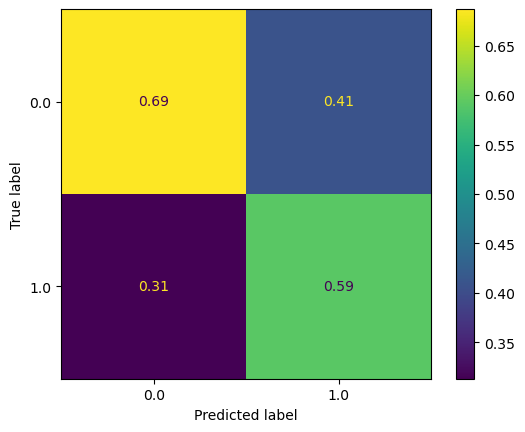

In [189]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [190]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [191]:
confusion_matrix(y_test, preds).ravel()

array([327, 110, 149, 159])

In [192]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [193]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(327, 110, 149, 159)

In [194]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.7482837528604119
Sensitivity:  0.5162337662337663
Precision:  0.5910780669144982
F1:  0.5511265164644715


##### Discussion

I tested many k values, and most led to a sensitivity score of less than 0.5. Even with the k value selected above, the F1 score does not exceed baseline.

This model cannot be used effectively to predict prevalence of diabetes.

## Taxes

In [195]:
file_path = '../data/FoodEnvironmentAtlas.xls.TAXES_Modeling.csv'

taxes = pd.read_csv(file_path)

In [196]:
taxes.head()

,fips,state,county,sodatax_stores14,sodatax_vendm14,chipstax_stores14,chipstax_vendm14,food_tax14,pct_diabetes18,class
0,1001,AL,Autauga,4.0,4.0,4.0,4.0,4.0,9.5,1.0
1,1003,AL,Baldwin,4.0,4.0,4.0,4.0,4.0,8.4,0.0
2,1005,AL,Barbour,4.0,4.0,4.0,4.0,4.0,13.5,1.0
3,1007,AL,Bibb,4.0,4.0,4.0,4.0,4.0,10.2,1.0
4,1009,AL,Blount,4.0,4.0,4.0,4.0,4.0,10.5,1.0


In [197]:
taxes.corr()

,fips,sodatax_stores14,sodatax_vendm14,chipstax_stores14,chipstax_vendm14,food_tax14,pct_diabetes18,class
fips,1.000000,0.080223,0.164036,-0.039005,0.077601,-0.039005,-0.083778,-0.084537
sodatax_stores14,0.080223,1.000000,0.776077,0.205402,0.457413,0.205402,-0.011687,-0.012025
sodatax_vendm14,0.164036,0.776077,1.000000,0.162108,0.704764,0.162108,0.050979,0.037553
chipstax_stores14,-0.039005,0.205402,0.162108,1.000000,0.266015,1.000000,0.157554,0.121925
chipstax_vendm14,0.077601,0.457413,0.704764,0.266015,1.000000,0.266015,0.119217,0.093480
food_tax14,-0.039005,0.205402,0.162108,1.000000,0.266015,1.000000,0.157554,0.121925
pct_diabetes18,-0.083778,-0.011687,0.050979,0.157554,0.119217,0.157554,1.000000,0.799640
class,-0.084537,-0.012025,0.037553,0.121925,0.093480,0.121925,0.799640,1.000000


### KNN Classification

#### 1. Create X and y

In [198]:
X = taxes.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = taxes['class']

#### 2. Determine baseline

In [199]:
taxes['class'].value_counts(normalize = True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

#### 3. Scale features

In [200]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify = y)

#### 5. Instantiate, fit, evaluate

In [202]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

# Instantiate
    knn = KNeighborsClassifier(n_neighbors = 17)

# Fit
    knn.fit(X_train, y_train)

# Evaluate
    print(knn.score(X_train, y_train), knn.score(X_test, y_test))

0.6608658743633277 0.6552162849872774


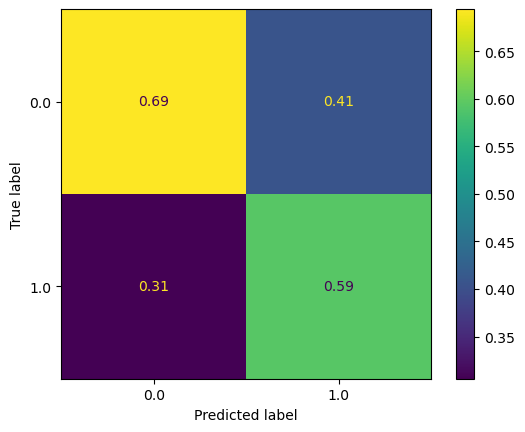

In [203]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, normalize = 'pred');

In [204]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)

    preds = knn.predict(X_test) #generates predictions

In [205]:
confusion_matrix(y_test, preds).ravel()

array([334, 124, 147, 181])

In [206]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [207]:
tn, fp, fn, tp #(true negative, false positive, false negative, true positive)

(334, 124, 147, 181)

##### Accuracy (pre-determined above)

In [208]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category = FutureWarning)
    
    print(knn.score(X_test, y_test))

0.6552162849872774


##### Additional Metrics

In [209]:
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision*sensitivity) / (precision+sensitivity)


print ("Specificity: ", specificity)
print ("Sensitivity: ", sensitivity)
print ("Precision: ", precision)
print ("F1: ", f1)

Specificity:  0.7292576419213974
Sensitivity:  0.551829268292683
Precision:  0.5934426229508196
F1:  0.5718799368088467


#### Discussion

After many attempts to find the optimal k-value, this model's F1 score still does not exceed baseline.

This model cannot be used effectively to predict prevalence of diabetes.

### Summary

There were two models whose F1 scores significantly exceed baseline: the ones created from the Health and Restaurants datasets respectively. The scores derived from these models were obtained easily, without any specific attempt to raise sensitivity/F1 scores. In contrast, I attempted many times to raise the sensitivity and F1 scores of the other datasets through changing the k-value. Following this, the F1 scores of the Assistance and Insecurity datasets also exceeded baseline at 0.623 each. While these scores are above baseline, I will focus on the Health and Restaurants datasets, which were shown to have even higher predictive power (0.706 and 0.675 respectively, following a Random Forest Classifier Grid Search.)

The Health dataset incorporates information regarding number of mental health providers, use of mental health services, and the number of recreational facilities in the county. Meanwhile, the Restauarants dataset contains information about the number of full service and fast food restaurants, along with the per capita spending on each. This indicates that perhaps these should be target areas to address for any counties hoping to lower their prevalence of diabetes. 

# Part II - Combining Datasets

As it has been established that the Health and Restaurants datasets can be predictive of diabetes prevalence in counties, my next step will be to see if their combined usage leads to increaed predictive power.

In order to do this, I will combine the two datasets into one, and then use Random Forest Classification with a Grid Search.

### Combining Health & Restaurant Datasets

In [210]:
health_restaurants = pd.concat([health, restaurants], axis = 1)

health_restaurants.head()

,fips,state,county,recfac11,recfac16,recfacpth11,recfacpth16,pct_mhs18,pct_mhs1825,pct_mhs26,...,fsr11,fsr16,fsrpth11,fsrpth16,pc_ffrsales07,pc_ffrsales12,pc_fsrsales07,pc_fsrsales12,pct_diabetes18,class
0,1001,AL,Autauga,4,6,0.072465,0.108542,13.0,11.0,13.0,...,32,31,0.579721,0.560802,649.511367,674.80272,484.381507,512.280987,9.5,1.0
1,1003,AL,Baldwin,16,21,0.085775,0.101200,13.0,11.0,13.0,...,216,236,1.157966,1.137300,649.511367,674.80272,484.381507,512.280987,8.4,0.0
2,1005,AL,Barbour,2,0,0.073123,0.000000,13.0,11.0,13.0,...,17,14,0.621549,0.543183,649.511367,674.80272,484.381507,512.280987,13.5,1.0
3,1007,AL,Bibb,0,1,0.000000,0.044183,13.0,11.0,13.0,...,5,7,0.219829,0.309283,649.511367,674.80272,484.381507,512.280987,10.2,1.0
4,1009,AL,Blount,3,4,0.052118,0.069490,13.0,11.0,13.0,...,15,12,0.260589,0.208471,649.511367,674.80272,484.381507,512.280987,10.5,1.0


In [211]:
restaurants_copy = restaurants.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

restaurants_copy.head()

,ffr11,ffr16,ffrpth11,ffrpth16,fsr11,fsr16,fsrpth11,fsrpth16,pc_ffrsales07,pc_ffrsales12,pc_fsrsales07,pc_fsrsales12
0,34,44,0.615953,0.795977,32,31,0.579721,0.560802,649.511367,674.80272,484.381507,512.280987
1,121,156,0.648675,0.751775,216,236,1.157966,1.137300,649.511367,674.80272,484.381507,512.280987
2,19,23,0.694673,0.892372,17,14,0.621549,0.543183,649.511367,674.80272,484.381507,512.280987
3,6,7,0.263794,0.309283,5,7,0.219829,0.309283,649.511367,674.80272,484.381507,512.280987
4,20,23,0.347451,0.399569,15,12,0.260589,0.208471,649.511367,674.80272,484.381507,512.280987


I can now combine this with the Health dataset.

In [212]:
health_restaurants = pd.concat([health, restaurants_copy], axis=1)

health_restaurants.head()

,fips,state,county,recfac11,recfac16,recfacpth11,recfacpth16,pct_mhs18,pct_mhs1825,pct_mhs26,...,ffrpth11,ffrpth16,fsr11,fsr16,fsrpth11,fsrpth16,pc_ffrsales07,pc_ffrsales12,pc_fsrsales07,pc_fsrsales12
0,1001,AL,Autauga,4,6,0.072465,0.108542,13.0,11.0,13.0,...,0.615953,0.795977,32,31,0.579721,0.560802,649.511367,674.80272,484.381507,512.280987
1,1003,AL,Baldwin,16,21,0.085775,0.101200,13.0,11.0,13.0,...,0.648675,0.751775,216,236,1.157966,1.137300,649.511367,674.80272,484.381507,512.280987
2,1005,AL,Barbour,2,0,0.073123,0.000000,13.0,11.0,13.0,...,0.694673,0.892372,17,14,0.621549,0.543183,649.511367,674.80272,484.381507,512.280987
3,1007,AL,Bibb,0,1,0.000000,0.044183,13.0,11.0,13.0,...,0.263794,0.309283,5,7,0.219829,0.309283,649.511367,674.80272,484.381507,512.280987
4,1009,AL,Blount,3,4,0.052118,0.069490,13.0,11.0,13.0,...,0.347451,0.399569,15,12,0.260589,0.208471,649.511367,674.80272,484.381507,512.280987


In [213]:
health_restaurants.columns

Index(['fips', 'state', 'county', 'recfac11', 'recfac16', 'recfacpth11',
       'recfacpth16', 'pct_mhs18', 'pct_mhs1825', 'pct_mhs26', 'rank18',
       'per100th18', 'rank17', 'per100th17', 'pct_diabetes18', 'class',
       'ffr11', 'ffr16', 'ffrpth11', 'ffrpth16', 'fsr11', 'fsr16', 'fsrpth11',
       'fsrpth16', 'pc_ffrsales07', 'pc_ffrsales12', 'pc_fsrsales07',
       'pc_fsrsales12'],
      dtype='object')

The columns are correct. I will check for null values.

In [214]:
health_restaurants.isnull().sum()

fips              0
state             0
county            0
recfac11          0
recfac16          0
recfacpth11       0
recfacpth16       0
pct_mhs18         0
pct_mhs1825       0
pct_mhs26         0
rank18            0
per100th18        0
rank17            0
per100th17        0
pct_diabetes18    0
class             0
ffr11             0
ffr16             0
ffrpth11          0
ffrpth16          0
fsr11             0
fsr16             0
fsrpth11          0
fsrpth16          0
pc_ffrsales07     0
pc_ffrsales12     0
pc_fsrsales07     0
pc_fsrsales12     0
dtype: int64

This appears correct. I will check the layout of the dataframe.

In [215]:
health_restaurants.shape

(3142, 28)

Both datasets contained all 3,142 counties, so this shape is correct.

I will now create the Random Forest Classifier.

### Random Forest Classifier

#### 1. Create X and y

In [216]:
X = health_restaurants.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = health_restaurants['class']

#### 2. Determine baseline

In [217]:
health_restaurants['class'].value_counts(normalize = True)

0.0    0.58275
1.0    0.41725
Name: class, dtype: float64

Baseline is 0.583.

#### 3. Scale features

In [218]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### 5. Instantiate & fit a preliminary model

In [220]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 6. Generate initial score

In [221]:
model.score(X_train, y_train), model.score(X_test, y_test)

(0.9991511035653651, 0.7531806615776081)

This model is highly overfit, but the accuracy score is 0.753.

#### 7. Grid search for best parameters

In [222]:
grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 6789),
                    param_grid = {'max_depth': [2, 8, 12, 16],
                                  'n_estimators':[20, 80, 120, 240],
                                 'min_samples_split': [2, 4, 6, 8],
                                 'min_samples_leaf': [2, 3, 4, 5, 6]},
                    
                                  cv=5, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=6789),
             param_grid={'max_depth': [2, 8, 12, 16],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [20, 80, 120, 240]},
             verbose=1)

In [223]:
grid.best_estimator_

RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=120, random_state=6789)

#### 4. Instantiate & fit with new parameters

In [224]:
rfc = RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=120, random_state=6789)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=120, random_state=6789)

#### 5. Evaluate

In [225]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9121392190152802, 0.7608142493638677)

This is lower than the original score, however the F1 score is the metric of interest. I will proceed with the rest of the evaluation.

On this occassion, I will check the F1 score, then compare it to the F1 score of the model with the original parameters.

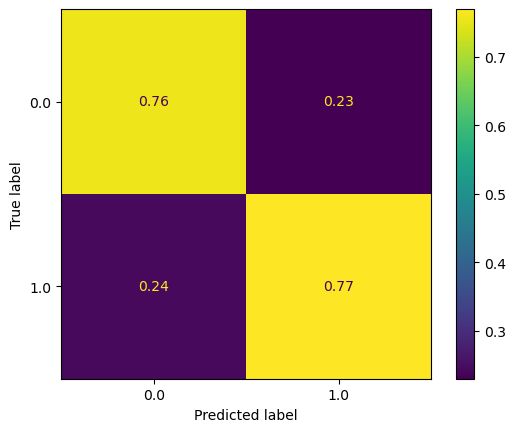

In [226]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, normalize = 'pred');

In [227]:
preds = rfc.predict(X_test)

In [228]:
f1_score(y_test, preds, pos_label=1)

0.7134146341463415

The f1 score is 0.713, which is higher than the F1 scores derived from Random Forest Classifiers created with the two datasets individually. Now, I will check the model that had the original parameters.

#### Discussion

Combining the two datasets led to an F1 score of 0.706, which is higher than the 0.701 which resulted from the Health Random Forest Classifier and the 0.676 which resulted from the Restaurants Random Forest Classifier.

For my last model, I will observe the predictive power of all datasets combined that have been used for modeling in this study (with the exception of Access10, as the full Access dataset will be used instead): Health, Access, Assistance, Insecurity, Local-Farmer's Market Payment, Local Farmer's Market - Foods, Restaurants, Socioeconomic, Stores- Convenience & Specialized, Stores - SNAP & WIC, and Taxes.

### Combining All Modified Food Environment Atlas Datasets

In [229]:
access_copy = access.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

assistance_copy = assistance.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

insecurity_copy = insecurity.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

local_fmp_copy = local_fmp.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

local_fmf_copy = local_fmf.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

sec_copy = sec.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

stores_cs_copy = stores_cs.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

stores_sw_copy = stores_sw.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

taxes_copy = taxes.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'] )

Now, I will combine the datasets.

In [230]:
all = pd.concat([health_restaurants, access_copy, assistance_copy, insecurity_copy, local_fmp_copy, local_fmf_copy,
                 sec_copy, stores_cs_copy, stores_sw_copy, taxes_copy], axis=1)

all.head()

,fips,state,county,recfac11,recfac16,recfacpth11,recfacpth16,pct_mhs18,pct_mhs1825,pct_mhs26,...,snapspth17,wics11,wics16,wicspth11,wicspth16,sodatax_stores14,sodatax_vendm14,chipstax_stores14,chipstax_vendm14,food_tax14
0,1001,AL,Autauga,4,6,0.072465,0.108542,13.0,11.0,13.0,...,0.804747,5.0,5.0,0.090567,0.090511,4.0,4.0,4.0,4.0,4.0
1,1003,AL,Baldwin,16,21,0.085775,0.101200,13.0,11.0,13.0,...,0.890836,26.0,28.0,0.139380,0.134802,4.0,4.0,4.0,4.0,4.0
2,1005,AL,Barbour,2,0,0.073123,0.000000,13.0,11.0,13.0,...,1.424614,7.0,6.0,0.255942,0.232387,4.0,4.0,4.0,4.0,4.0
3,1007,AL,Bibb,0,1,0.000000,0.044183,13.0,11.0,13.0,...,0.801423,6.0,5.0,0.263771,0.221474,4.0,4.0,4.0,4.0,4.0
4,1009,AL,Blount,3,4,0.052118,0.069490,13.0,11.0,13.0,...,0.692374,8.0,8.0,0.139000,0.139089,4.0,4.0,4.0,4.0,4.0


In [231]:
all.shape

(3142, 116)

In [232]:
all.columns.values.tolist()

['fips',
 'state',
 'county',
 'recfac11',
 'recfac16',
 'recfacpth11',
 'recfacpth16',
 'pct_mhs18',
 'pct_mhs1825',
 'pct_mhs26',
 'rank18',
 'per100th18',
 'rank17',
 'per100th17',
 'pct_diabetes18',
 'class',
 'ffr11',
 'ffr16',
 'ffrpth11',
 'ffrpth16',
 'fsr11',
 'fsr16',
 'fsrpth11',
 'fsrpth16',
 'pc_ffrsales07',
 'pc_ffrsales12',
 'pc_fsrsales07',
 'pc_fsrsales12',
 'pct_laccess_pop10',
 'pct_laccess_pop15',
 'pct_laccess_lowi10',
 'pct_laccess_lowi15',
 'pct_laccess_hhnv10',
 'pct_laccess_hhnv15',
 'pct_laccess_snap15',
 'pct_laccess_child10',
 'pct_laccess_child15',
 'pct_laccess_seniors10',
 'pct_laccess_seniors15',
 'pct_snap12',
 'pct_snap17',
 'snap_part_rate11',
 'snap_part_rate16',
 'pct_nslp12',
 'pct_nslp17',
 'pct_sbp12',
 'pct_sbp17',
 'pct_wic12',
 'pct_wic17',
 'pct_wicinfantchild14',
 'pct_wicinfantchild16',
 'pct_wicwomen14',
 'pct_wicwomen16',
 'pct_cacfp12',
 'pct_cacfp17',
 'fdpir12',
 'fdpir15',
 'food_banks18',
 'foodinsec_12_14',
 'foodinsec_15_17',
 'ch_

The columns look correct. I will need to drop rows with null values, so unfortunately, I will not be able to predict for all counties.

In [233]:
all.isnull().sum().values.tolist() #shows list of number of missing values

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 19,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 164,
 164,
 164,
 164,
 164,
 164,
 164,
 164,
 0,
 0,
 0,
 0,
 0]

It is confirmed that there are null values. I will drop them below.

In [234]:
all = all.dropna()

In [235]:
all.shape

(2978, 116)

Everything is in place. I will now create a Random Forest Classifier using the data.

### Random Forest Classification

#### 1.Create X and y

In [236]:
X = all.drop(columns = ['fips', 'state', 'county', 'pct_diabetes18', 'class'])

y = all['class']

#### 2. Determine baseline

In [237]:
all['class'].value_counts(normalize = True)

0.0    0.579584
1.0    0.420416
Name: class, dtype: float64

Baseline is 0.580.

#### 3. Scale features

In [238]:
ss = StandardScaler()

X = ss.fit_transform(X)

#### 4. Train, test, split

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [240]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2233, 111), (745, 111), (2233,), (745,))

#### 5. Instantiate & fit the model

In [241]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### 6. Generate initial score

In [242]:
model.score(X_train, y_train), model.score(X_test, y_test)

(1.0, 0.7543624161073825)

With a train score of 1.0, the overfit is extreme, however the accuracy score is 0.754.

#### 7. Grid search for best parameters

In [243]:
grid = GridSearchCV(estimator = RandomForestClassifier(random_state = 6789),
                    param_grid = {'max_depth': [2, 8, 12, 16],
                                  'n_estimators':[20, 80, 120, 240],
                                 'min_samples_split': [2, 4, 6, 8],
                                 'min_samples_leaf': [2, 3, 4, 5, 6]},
                    
                                  cv=5, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=6789),
             param_grid={'max_depth': [2, 8, 12, 16],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [20, 80, 120, 240]},
             verbose=1)

In [244]:
grid.best_estimator_

RandomForestClassifier(max_depth=16, min_samples_leaf=4, n_estimators=240,
                       random_state=6789)

#### 4. Instantiate & fit with new parameters

In [245]:
rfc = RandomForestClassifier(max_depth=16, min_samples_leaf=4, n_estimators=240,
                       random_state=6789)

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=4, n_estimators=240,
                       random_state=6789)

#### 5. Evaluate

In [246]:
rfc.score(X_train, y_train), rfc.score(X_test, y_test)

(0.9583519928347515, 0.748993288590604)

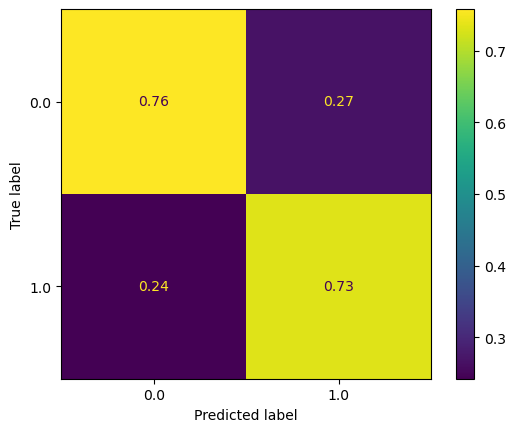

In [247]:
ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, normalize = 'pred');

In [248]:
preds = rfc.predict(X_test)

In [249]:
f1_score(y_test, preds, pos_label=1)

0.6792452830188679

##### Discussion

The F1 score for the entire dataset is is lower than that of the Random Forest Classifier using solely the Health and Restaurant datasets. The model including all datasets also seems to have a high amount of overfit, as seen in the large difference between the train (0.958) and test (0.749) sets.

However, at 0.679, the model still exceeds the baseline value of 0.580. Thus, it can be said that overall, a county's Food Environment can be used to predict high or low prevalence of diabetes.

# III. Conclusion, Recommendations, & Next Steps

In completing this study, I set out to determine how well I could predict prevalence of diabetes in U.S. counties using food environmental features. As it turns out, some of these factors are fairly predictive of diabetes. For example, in the Random Forest Classification model combining Health and Restaurants datasets, when the model predicts that a county is low prevalence, it is correct 76% of the time. When the model predicts that a county is high prevalence, it is correct 77% of the time. These datasets are older, with the most recent information being 5 years old. However, what can be learned from these models is that there are in fact certain aspects of a community that can be predictive of diabetes. 

It was interesting to note that the Health dataset produced the most predictive model. Specifically, the Health dataset included information about recreational/fitness facilities, mental health providers, and percentage of the adult population receiving mental health services. This suggests that community leaders can work toward decreasing prevalence of diabetes by encouraging use/presence of recreational facilities. Communities can also stress the importance of receving proper mental health care, and encourage young community members to select career choices that involve mental health care. I stress the mental health care part of this specifically, because the connection between mind and body is something that is often not fully appreciated. The results of this study indicate that full importance should be placed on mental health treatment.

Additionally, the second highest-scoring individual model was the Restaurants dataset. This suggests that communities could stress the benefits of limiting fast food spending, and perhaps engage in outreach and education regarding healthier food options that fit within a limited budget. While information regarding reprsentation of ethnic groups within counties was not included in the current study, disparities between ethnic groups can be seen [here](https://diabetes.org/newsroom/press-releases/2021/income-related-inequalities-in-diabetes-have-widened-over-past-decade-cdc-study-finds). Therefore, it becomes important for community leaders to provide interventions tailored to the specific population they serve, its customs, cultural foods, and so on.

Finally, while I did not stress their presence in the overall findings, I do want to note that the Food Insecurity and Assistance datasets produced models that were an improvement over baseline. This seems indicative of the overall connection between low income and diabetes, also addressed [here](https://diabetes.org/newsroom/press-releases/2021/income-related-inequalities-in-diabetes-have-widened-over-past-decade-cdc-study-finds). Given the fact that the federal minimum wage is not enough to meet living expenses (see this [website](https://livingwage.mit.edu/articles/99-a-calculation-of-the-living-wage)), those who are very low income might experience limited food options and high levels of chronic stress. It is sensible, then, that they might experience higher rates of diabetes.  

If continuing to research this topic, I have multiple thoughts about the next steps I could take. Firstly, I would like to continue to research the impact of mental health and mental health services on the prevention and treatment of physical disease states. Additionally, I would like to conduct further research on the potential savings of preventative healthcare, both in terms of lives, and healthcare costs (see this [website](https://diabetes.org/about-us/statistics/about-diabetes), reporting $327 billion costs on diagnosed diabetes in 2017.) Finally, I would like to research the potential benefits in terms of overall health in raising minimum wage. My hope in doings so is that community leaders will become empowered to promote effective change.